**By: Nathan Burns**    


# Linear Regression for IMDB Movie Ratings
## Introduction

This is the capstone project for Coursera's *Linear Regression and Modeling* course, taught by Mine Çetinkaya-Rundel of Duke University. We are provided with a dataset of movies from IMDB which includes data regarding ratings, genres, release dates, whether or not each movie was directed by a winner of an Oscar, and more. We would like to dive into the data and see if we can find anything interesting.

## Motivation

In a time when movie options are abundant, it would be beneficial to be able to narrow our search for a good last-minute movie with the help of some data. It would be nice if we could build a high-performing linear regression model that predicts movie ratings. With just 651 points and less than 20 relevant variables in the original dataset, though, that might be asking a lot. For this reason we would be content just to successfully identify some significant predictors of movie ratings.

To measure movie quality we use the 'rating' variable, which is the IMDB rating (1-10). We will compare this variable to multiple explanatory variables to see which can indeed contribute predictive power to the quality of a movie. 

(The original dataset also includes variables for critic ratings and audience ratings, as well as number of IMDB votes. It turns out that each IMDB rating is based on a respectable sample size of at least 180, whereas the sample sizes for critic and audience ratings are unclear, and presumably small. For this reason we have chosen IMDB rating to be our target.) 


## Data Collection

We are told that the dataset is a random sample of movies from IMDB. When we make a histogram of the IMDB ratings in our dataset and compare it to the one found at this link (http://collider.com/imdb-ratings-statistics/) we find similar graphs, which supports this claim of randomness. We are also explicitly told by a professor of a reputable university that the sample is random, so it is safe to assume that it is indeed random. We can therefore use our results to generalize to the population level using correlation. There was no random assignment that was performed though so we need to be mindful not to speak in the language of causality throughout our analysis.

## Research Goals

**Primary Goal:** Determine which variable(s) can be used to predict IMDB movie ratings  --------------------------------  (looking at p-values)

**Secondary Goal:** Build a linear regression model that predicts IMDB movie ratings  ----------------------  (looking at adjusted R-squared)

## Exploratory Data Analysis

### Load the data and libraries

We'll begin by loading the data and packages that will be needed throughout this project.

In [43]:
library(tidyverse) #for dplyr and ggplot2
library(ggthemes)  #for modifying ggplot2 graphics
library(gridExtra) #for grid.arrange()
library(lubridate) #for manipulating date variables
library(repr)      #for sizing plots

movies = as.tibble(read.csv("movies_dataset.csv"))

###  Transform the dataset

Now that we have our data and relevant tools loaded, let's take a look at what the original movies dataset has to offer:

In [45]:
movies[1,]

X,title,title_type,genre,runtime,mpaa_rating,studio,thtr_rel_year,thtr_rel_month,thtr_rel_day,...,best_dir_win,top200_box,director,actor1,actor2,actor3,actor4,actor5,imdb_url,rt_url
1,Filly Brown,Feature Film,Drama,80,R,Indomina Media Inc.,2013,4,19,...,no,no,Michael D. Olmos,Gina Rodriguez,Jenni Rivera,Lou Diamond Phillips,Emilio Rivera,Joseph Julian Soria,http://www.imdb.com/title/tt1869425/,//www.rottentomatoes.com/m/filly_brown_2012/


**A quick glance at the variable list above should convince you that:** <br />

•   There are many irrelevant variables. <br />
•   The variable naming scheme could be improved. <br />
•   *thtr_rel_month* (1-12) might be clearer if replaced by month names. <br />
•   *best_actor_win* and *best_actress_win* can be combined into a single variable best_actor. <br /> <br />

<div style="text-align: justify"> We combine actors and actresses because the classes for both are already skewed (with many more 'no' values than 'yes'). Combining them reduces the skewness. Now let's apply the above changes: </div>

In [46]:
movies = movies %>%
  rename(type=title_type, length=runtime, maturity=mpaa_rating, year=thtr_rel_year, month=thtr_rel_month, day=thtr_rel_day, rating=imdb_rating, best_director=best_dir_win) %>% 
  mutate(best_actor=(best_actor_win=='yes' | best_actress_win=='yes'), month=month(month, label=TRUE)) %>%
  select(2:10, 14, 24, 34)
  

Before we start really analyzing our data we should inspect some of the categorical variables to check whether or not each class has sufficient data to draw conclusions from. Let's start with *type*:

In [47]:
summary(movies$type)


Documentary Feature Film     TV Movie 
          55          591            5

There are only 5 movies that were classified as a *TV Movie*, and tv movies are likely lower in their ratings than feature films and documentaries, so they can't reliably be collapsed into the *Documentary* or *Feature Film* classes. The best approach here is to just eliminate these 5 points:

In [48]:
movies = movies %>% filter(type!="TV Movie")
movies$type=factor(movies$type)  #This gets rid of the now-empty level

Now let's look at maturity:

In [49]:
summary(movies$maturity)

G   NC-17      PG   PG-13       R Unrated 
     19       2     118     133     326      48

Most of the data is concentrated in the *PG*, *PG-13* and *R* classes. That being said, there are still 69 points between the *G*, *NC-17* and *Unrated* classes, which is not a negligible amount considering the full dataset consists of only a few hundred points. Rather than eliminating the points with these classes we will instead collapse them into a single class called *Other*: 

In [50]:
movies$maturity = movies$maturity %>% fct_collapse('Other'=c('G', 'NC-17', 'Unrated'))

And now for *studio* - notice how many classes this variable has:

In [51]:
movies$studio %>% levels() %>% length()

[1] 211

This is far too many classes for the *studio* variable given our dataset size, so we will keep the 4 most abundant classes excluding *(Other)* and collapse the rest into a single class called *Other* (no parentheses). Let's find out which are the top 4 studios:

In [52]:
movies$studio %>% summary() %>% sort() %>% tail(5)

Universal Pictures Sony Pictures Home Entertainment 
                              23                               27 
           Warner Bros. Pictures               Paramount Pictures 
                              30                               37 
                         (Other) 
                             111

In [53]:
#Collapsing the levels
levels(movies$studio) = union(levels(movies$studio), 'Other')

movies$studio[!(movies$studio %in% c('Paramount Pictures', 'Warner Bros. Pictures', 'Sony Pictures Home Entertainment', 'Universal Pictures'))] = 'Other'
movies$studio = factor(movies$studio)  #This gets rid of the now-empty levels

Now consider the *best_actor* and *best_director* variables:

In [54]:
class(movies$best_actor)

levels(movies$best_director)

[1] "logical"

[1] "no"  "yes"

Notice:

•   *best_actor* is logical - *TRUE* if any cast member has ever won an Oscar, *FALSE* otherwise  <br />
•   *best_director* is categorical - *yes* if the director has won an Oscar for any movie, *no* otherwise  <br />

For consistency, let's convert *best_actor* to a categorical variable where *FALSE*->*no* and *TRUE*->*yes*.

In [55]:
movies$best_actor = as.factor(movies$best_actor)

levels(movies$best_actor)[levels(movies$best_actor)==FALSE] = 'no'
levels(movies$best_actor)[levels(movies$best_actor)==TRUE] = 'yes'

Let's now take care of any missing values that may have arisen in our dataset.

In [56]:
sum(is.na(movies))

[1] 1

We see that there's just one missing value that needs to be taken care of. If we were to look at summary(movies) we would find that this missing value occurs in the *length* variable. That's convenient - we can just identify the title of this movie then look up the movie length online:

In [57]:
i = which(is.na(movies$length))
as.character(movies$title[i])

[1] "The End of America"

A quick Google search will reveal that *The End of America* is 1h 14m long, so we can fill in the missing value with 74.

In [58]:
movies$length[i] = 74

We now have our dataset and variables in good form. For future reference, let's take a look at what a typical row in the updated version of the dataset looks like: 

In [59]:
movies[1,]

title,type,genre,length,maturity,studio,year,month,day,rating,best_director,best_actor
Filly Brown,Feature Film,Drama,80,R,Other,2013,Apr,19,5.5,no,no


### Univariate analysis

Let's get to know our variables better. We will begin by creating a bar chart for each of the categorical variables that might be important and a histogram for each of the continuous variables that might be important. Note that:

• In each of the charts the y-axis is understood to be a count of the number of movies produced, grouped by the x-axis variable. <br /> • The stated values along the y-axes are the minimum/maximum bar heights/counts in each bar graph (in blue) and histogram (in red). <br />
• *Best Actor?* refers to whether or not there is an Oscar-winning actor (for any movie) in the cast. <br />
• *Best Director?* refers to whether or not the director of the movie has won an Oscar (for any movie). <br />
• *Feature Film?* corresponds to the *type* variable. <br />
• *Day of Month (1-31), Month* and *Year* refer to theater release dates.

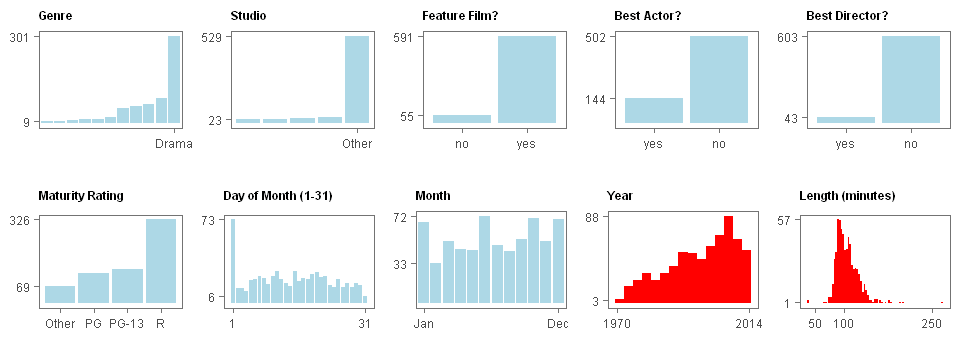

In [21]:
options(repr.plot.width=8, repr.plot.height=3)
grid.arrange(g1,g2,g3,g4,g5,g6,g7,g8,g9,g10, nrow=2)
#The code for g1-g10 can be found at the end of this project.

**Some observations about the variables:**

•  *genre* is heavily skewed towards the *Drama* class. <br />
•  *type* is heavily skewed towards the *Feature Film* class. <br />
•  R-rated movies are the most common, but the other classes still have respectable sample sizes. <br />
•  *studio* is heavily skewed towards the *Other* class (which makes sense given that we collapsed all but the top 4 studios into one class). <br />
•  *best_actor* and *best_director* are heavily skewed towards the *no* class. <br />
•  Movies are released much more frequently on the first day of a month. <br />
•  The distribution for the number of movies released per month is noisy. <br />
•  More movies are being released per year as time goes on. <br />
•  Movies that are around 100 minutes (1h 40m) in length are the most common. <br />
•  There's at least one movie that's >250 minutes and at least one that is <50 minutes. (outliers)

Before proceeding let's take a closer look at the *genre* variable.

In [22]:
sort(summary(movies$genre))

Animation Science Fiction & Fantasy Musical & Performing Arts 
                        9                         9                        12 
Art House & International                     Other                    Horror 
                       14                        15                        23 
              Documentary        Mystery & Suspense        Action & Adventure 
                       52                        59                        65 
                   Comedy                     Drama 
                       87                       301

We see both from the bar chart and the summary table that there is a disproportionately high number of drama movies in our dataset. However, it is not entirely clear how the genre is determined for each movie in this dataset, given that movies on the IMDB website are classified under multiple genres. Perhaps this dataset just uses the first genre that appears in a movie's genre list on IMDB, or it could plausibly be that this dataset uses the most dominant genre for each movie. In any case, we should be mindful that about half of the movies in our dataset can be classified as drama films.

Now let's inspect the *length* variable on account of its apparent outliers. We see that there are movies with runtimes less than 50 minutes or greater than 250 minutes. Which movies are these?

In [23]:
(movies %>% filter(length<50 | length>250))[1:4]

title,type,genre,length
Africa: The Serengeti,Documentary,Documentary,39
Hotel Terminus: The Life and Times of Klaus Barbie,Documentary,Documentary,267
Sea Monsters: A Prehistoric Adventure,Documentary,Documentary,40


The extremely short and extremely long movies are all documentaries. That makes sense; we generally wouldn't expect feature films to be as short as 39 minutes or as long as 267 minutes. In this case we won't remove our outliers, because as we will see shortly, documentaries are movies of particular interest in this dataset. 

### Bivariate analysis

In this section we will compare the candidate explanatory variables to the target variable, *rating*. Let's begin with the *best_actor* and *best_director* variables.

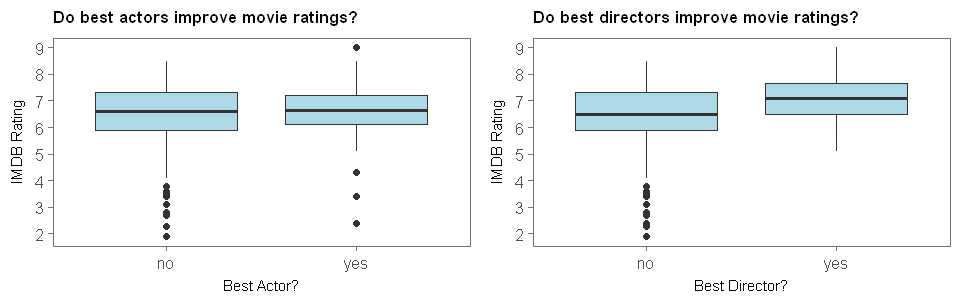

In [25]:
options(repr.plot.width=8, repr.plot.height=2.5)
grid.arrange(g11,g12, nrow=1)
#The code for g11 and g12 can be found at the end of this project.

 **Best Actor**: We see that the first, second and third quartiles (the boxes) are similar for movies that include an Oscar-winning actor in their cast and those that don't. Due to the multitude of points beneath the lower whisker for the *no* class and due to the singular point above the upper whisker in the *yes* class, it would be tempting to conclude that movies with best actors are more likely to receive very high ratings, and movies without best actors are more likely to get very low ratings. This would coincide with our human intuition, and is probably true. There are so few points beyond the whiskers though, so we should remain open to changing our minds if presented with sufficient reason to. <br /> 


**Best Director**: Here we see a noteworthy difference in the two boxplots. The first, second and third quartiles are noticeably higher for movies directed by an Oscar-winning director than for movies directed by someone who hasn't won an Oscar - nothing surprising there. Furthermore, there are no low-rating movies that were produced by Oscar-winning directors. We saw in the univariate section that there are only 43 movies in the dataset with an Oscar-winning director though, so we'll need to be mindful of sample sizes when using this variable in the linear regression section. 

Next we will consider side-by-side boxplots for the *genre* and *type* variables.

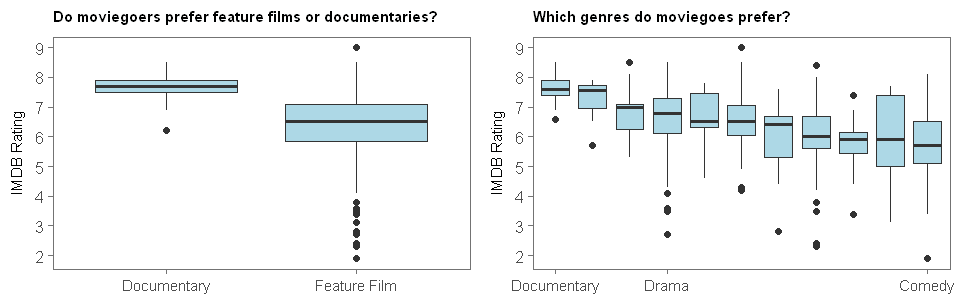

In [63]:
options(repr.plot.width=8, repr.plot.height=2.5)
grid.arrange(g13,g14, nrow=1)
#The code for g13 and g14 can be found at the end of this project.

**Type** (*Documentary / Feature Film*): Notice that even the first quartile of the *Documentary* boxplot is higher than the third quartile of the *Feature Film* boxplot, so there is an unmistakeable difference in movie ratings for the two types. Moreover, the variability of the ratings is small for documentaries, as seen by the lower IQR (i.e. the box is narrower). We should keep this in mind when building our linear regression model, as it might help improve our predictive capabilities for the documentaries in our dataset.


**Genre:** When we order the boxplots by decreasing median we see that there is a noticeable difference across the various genres. I find it surprising that *Comedy* would be the least popular genre. I'm curious - which comedy movie is it that is receiving such a terrible IMDB rating, all the way at the bottom-right of the graph? 

In [64]:
badComedy = movies %>% filter(genre=="Comedy", rating<3)
as.character(badComedy$title)

[1] "Disaster Movie"

(Note to self: *Disaster Movie* is a disastrous movie.) <br /> <br /> Even more surprising to me is that the *Documentary* genre would receive the highest ratings, which further supports what was uncovered in the *Type* graph. Are *maturity* or *studio* correlated to movie ratings? Let's find out:




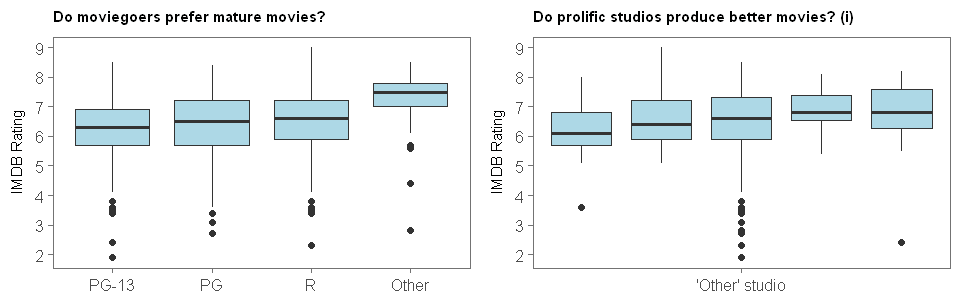

In [65]:
options(repr.plot.width=8, repr.plot.height=2.5)
grid.arrange(g15,g16, nrow=1)
#The code for g15 and g16 can be found at the end of this project.

**Maturity:** The boxplots for *PG-13, PG* and *R* movies are comparable to one another. There is however a noticeable jump when comparing them to the *Other* boxplot. Referring back to our univariate section we saw that 48 out of 69 (70%) of the *Other* movies were originally *Unrated*, so we can't really say too much about the specifics of this class. What we can say is that, due to this difference, *maturity* is a variable worth considering when building our linear regression model. <br /> 

**Studio:** We have a boxplot for each of the 4 studios that have produced the most movies, and a fifth that combines all of the other studios. When we arrange these 5 classes by increasing median we see that the *Other* boxplot occurs in the middle. It looks as though the median for *Other* is about midway between the medians of the other 4 boxplots. Let's inspect this further by collapsing those 4 studios into one before comparing to *Other*. 

In [66]:
movies$studio2 = movies$studio %>%
  fct_collapse('Top4'=c('Paramount Pictures', 'Warner Bros. Pictures', 'Sony Pictures Home Entertainment', 'Universal Pictures'))

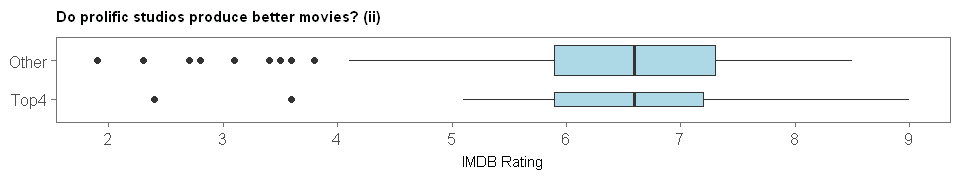

In [69]:
options(repr.plot.width=8, repr.plot.height=1.5)
g17          
#The code for g17 can be found at the end of this project.

When we compare the 4 most prolific studios combined to all of the other studios combined we see that their medians are exactly the same. Moreover, there are more bad movies (outliers) in *Other*, but not disproportionately more when taking into account class size (shown by the width of each box). However, by comparing the right whiskers we see that the maximum movie rating for a top-4 studio is higher than for any other studio, despite the smaller sample of movies being considered. <br /> 

**To summarize *Studio*:** It doesn't look seem as though *studio* will be a significant predictor of movie ratings, but it might offer some predictive value, so we will keep it in mind when building our linear regression model. <br />

Before we conclude our bivariate analysis we will consider our time-related variables. 

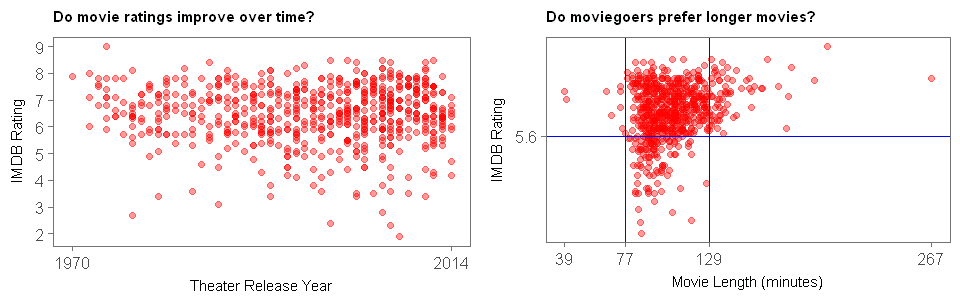

In [70]:
options(repr.plot.width=8, repr.plot.height=2.5)
grid.arrange(g18,g19, nrow=1)
#The code for g18 and g19 can be found at the end of this project.

**Theater Release Date:** There is no obvious change in movie ratings over the years, and if we were to make charts comparing IMDB ratings to theater release dates by month or day of the month then we would arrive at a similar conclusion. <br />  

**Movie Length:** As for the movie length scatterplot, notice the empty box at the bottom-right of the graph. There is a reasonable sample size of movies that are greater than 129 minutes in length, none of which have an IMDB rating less than 5.6. This shows that moviegoers are generally satisfied with long movies. The movies that get poor ratings tend to be shorter, around 77-129 minutes in length. This might be a matter of sample size; we saw earlier that the movie length distribution is heavily weighted around 90 minute films. That being said, if movie ratings truly were uncorrelated to movie length, then we would expect the fraction of movies greater than 129 minutes that have an IMDB rating less than 5.6 would be comparable to the fraction of movies between 77-129 minutes that have an IMDB rating less than 5.6; in other words, we would expect at least *a few* long movies with poor ratings. That's not the case though. We are therefore encouraged to conclude that movie length is indeed positively correlated with movie rating. <br />  

***Important reminder:***  *We need to be careful not to speak in the language of causality though. Are people satisfied with long movies because they prefer an extended experience, or could it instead be that there is a confounding variable positively driving both movie length and IMDB rating, such as movie budget? Such a question is out of the scope of this project, but it is something that would be interesting to look into in the future.*






## Individual p-values

We are now ready to compute the p-value for each of our explanatory variables when predicting *rating* individually. <br /> 

In [75]:
tibble(variable = colnames(movies)[3:12], pvalue = signif(pvalue,3), significant=pvalue<0.05)
#The code for pvalue can be found at the end of this project in the "Computing p-values" section

variable,pvalue,significant
type,4.19e-18,TRUE
genre,1.89e-31,TRUE
length,1.53e-11,TRUE
maturity,6.64e-10,TRUE
studio,1.52e-01,FALSE
year,4.84e-01,FALSE
month,4.37e-01,FALSE
day,7.57e-01,FALSE
best_director,5.69e-04,TRUE
best_actor,9.40e-02,FALSE


There is consistency between what we saw in our bivariate analysis section and the p-values:

•**The significant individual predictors of *rating*** (p-value < 0.05)**:**  *type*, *genre*, *length*, *maturity*, *best_director* <br /> This is consistent with what we predicted from our bivariate analysis.

•**The insignificant individual predictor of *rating*:** *best_actor* <br /> With a p-value of 0.094 it is somewhat close to being significant but doesn't quite make the cut. <br /> This is consistent with what we hypothesized in our bivariate analysis, that *best_director* would be significant but *best_actor* wouldn't.

•**The very insignificant individual predictors of *rating*** (p-value > 0.15)**:** *studio*, *year*, *month*, *day* <br />
This is consistent with what we observed in our bivariate analysis. 

### Multicollinearity

There could be multicollinearity among the significant individual predictors. In particular, both *type* and *genre* have the *Documentary* class, and this class has the highest ratings for both. Let's compare them: 

In [34]:
lineDocumentary = lm(rating ~ type+genre, data=movies)
signif(summary(lineDocumentary)$coefficients[c(2,7),], 3)

,Estimate,Std. Error,t value,Pr(>|t|)
typeFeature Film,-0.853,0.347,-2.46,1.42e-02
genreDrama,0.704,0.129,5.44,7.80e-08


The variables *type* and *genre* have small individual p-values when predicting *rating* (4.19e-18 and 1.89e-31). When we build a model that includes both variables we see that they once again have factors with small p-values, despite the correlation between *type* and *genre*. <br /> 

We could continue by making a similar comparison for every pair of significant variables. For example, we might suspect that *genre* and *maturity* are highly correlated (horror films are more likely to be rated R). It might also be that *length* and *genre* are highly correlated (movies for children are more likely to be shorter). However, with just 10 explanatory variables available to us, only 5 of which were shown to be significant predictors of movie ratings, it's probably best to just keep them all. 

## Linear Regression

### Model with significant predictors

Let's first build the multiple regression model which predicts *rating* from the 5 significant predictors:

In [82]:
lineSignificant = lm(rating ~ type+genre+length+maturity+best_director, data=movies)
summary(lineSignificant)


Call:
lm(formula = rating ~ type + genre + length + maturity + best_director, 
    data = movies)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8746 -0.4952  0.0512  0.5821  1.9761 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     5.806251   0.415780  13.965  < 2e-16 ***
typeFeature Film               -0.757860   0.333623  -2.272  0.02345 *  
genreAnimation                 -0.093337   0.333755  -0.280  0.77983    
genreArt House & International  0.551802   0.268971   2.052  0.04063 *  
genreComedy                    -0.109635   0.149537  -0.733  0.46373    
genreDocumentary                0.839697   0.356689   2.354  0.01887 *  
genreDrama                      0.593732   0.125934   4.715 2.98e-06 ***
genreHorror                    -0.161392   0.223265  -0.723  0.47003    
genreMusical & Performing Arts  0.858861   0.305307   2.813  0.00506 ** 
genreMystery & Suspense         0.383836   0.166064   2.311  0

**Regression Analysis:** We see that the adjusted R-squared is 0.2993, which isn't spectacular but is still sufficient to offer a predictive edge over blind guessing movie quality. There are numerous encouraging details when we inspect the p-values and coefficient signs in this model:

In [86]:
signif(summary(lineSignificant)$coefficients[c(2,7,13:17),], 3)

,Estimate,Std. Error,t value,Pr(>|t|)
typeFeature Film,-0.7580,0.33400,-2.27,2.34e-02
genreDrama,0.5940,0.12600,4.71,2.98e-06
length,0.0122,0.00202,6.06,2.28e-09
maturityPG,-0.3630,0.15900,-2.28,2.27e-02
maturityPG-13,-0.6010,0.16300,-3.69,2.40e-04
maturityR,-0.2890,0.14900,-1.94,5.30e-02
best_directoryes,0.4260,0.14800,2.88,4.11e-03


**p-value:** Each of the variables has at least one class that has a p-value < 0.05. <br />

**Coefficient signs** (looking at the *Estimate* column)**:** <br />
•*typeFeature Film* is negative; with all other variables held constant, documentaries rate higher than feature films. <br />
•*length* is positive; with all other variables held constant, longer movies rate higher. <br />
•*maturityPG, maturityPG-13* and *maturityR* are negative; with all other variables held constant, movies from the *maturityOther* class rate the highest. <br />
•*best_directoryes* is positive; with all other variables held constant, movies that are directed by an Oscar winner rate higher than those that aren't.

These coefficient signs are encouraging because they agree with what we found in our bivariate analysis for each of these variables. 

### All possible models approach

When in search of the optimal subset of predictors for a model it would generally be a bad strategy to construct every model and extract the one with the best evaluation metric value due to the exponential growth of the number of models to be tested. In our case however we only have 10 candidate predictors, which amounts to a mere 2^10 = 1024 models. In this section we will take the approach of building each of the possible models and extracting the best one before comparing it to *lineSignificant*. <br /> 

To build all 1024 models we will use the *all.possible.regressions()* function, whose code can be found at the end of this project. 

In [87]:
#This function requires that our target variable be renamed y and our explanatory variables as x1, x2, x3, ... 
moviesALL = movies %>% 
  select(y=rating, x1=type, x2=genre, x3=length, x4=maturity, x5=studio, x6=year, x7=month, x8=day, x9=best_director, x10=best_actor)

#This is a dataframe that includes all 1024 models and their adjusted R-squared values, among other metrics.
apr = all.possible.regressions(moviesALL,10)

This is how a typical row in the *apr* data frame looks:

In [88]:
apr[345,]

,model,df.sse,p,SSE,MSE,R2,R2.adj,AIC,BIC
345,y ~ 1+x1+x2+x3+x6+x8+x10,630,15,530.7348,0.8424361,0.2914964,0.2746272,4087.174,4163.177


We are interested in the model with the highest adjusted R-squared (*R2.adj*):

In [89]:
m = which.max(apr$R2.adj)
tibble(model=apr$model[m], R2.adj=round(apr$R2.adj[m],4))

model,R2.adj
y ~ 1+x1+x2+x3+x4+x5+x6+x9,0.3127


The adjusted R-squared has increased somewhat, from 0.2993 for the model using the 5 significant predictors, to 0.3127 using variables x1-x6 and x9. Translating back into our original variable names, this model uses *type, genre, length, maturity, studio, year* and *best_director*. Encouragingly, this model includes all of the 5 significant predictors. It also include 2 others that we missed previously, *studio* and *year*, which goes to show that taking an all possible models approach might be the best default strategy in the future when data frames are small like the one in this project. <br /> 

Let's now build this model and inspect its summary:  
(*Note: We won't include the full summary, which would be long due to one-hot encoding for each of the categorical variables.*)

In [90]:
lineBest = lm(rating~type+genre+length+maturity+studio+year+best_director, data=movies)

#Include particular features of interest generated by one-hot encoding, rounded to 3 significant figures:
summaryBest = summary(lineBest)$coefficients[c(2,7,13,15,17,21,22 ),]
summaryBest = signif(sla,3)

#Display the significance codes for the selected features to be displayed:
cbind(summaryBest, significance=c("*", "***", "***", "***", "*", "", "**"))

,Estimate,Std. Error,t value,Pr(>|t|),significance
typeFeature Film,-0.828,0.332,-2.5,0.0128,*
genreDrama,0.645,0.125,5.14,3.62e-07,***
length,0.0108,0.00204,5.28,1.82e-07,***
maturityPG-13,-0.637,0.164,-3.89,0.00011,***
studioSony Pictures Home Entertainment,-0.503,0.231,-2.18,0.0297,*
year,-0.00472,0.00349,-1.35,0.178,
best_directoryes,0.434,0.147,2.95,0.0033,**


**Some observations about the significances and coefficients (*Estimates*):** <br /> 

 

•The coefficients for *best_directoryes* and *length* are positive, and for *typeFeature Film* are negative. This is in agreement with what we concluded before: longer movies or movies directed by an Oscar-winner are more likely to receive higher ratings, and feature films are more likely to receive a lower rating than documentaries. <br /> <br />
•If we were to print the full summary we would see that *drama* is the most significant predictor of *rating* among the different genres. This is likely a consequence of the fact that our dataset is comprised of disproportionately-many drama movies. <br/ > <br/ >
•*length*, as well as at least one class from *genre* and *maturity* each, have \*\*\* significances -- no surprise given that we have suspected they are strongly correlated with movie ratings all along. <br /> <br />
•*best_director* receives a significance of \*\*. I imagined it would have been \*\*\*, but \*\* isn't so far off. I'm more surprised by the single \* significance from the *type* variable, given the significant difference between the *Feature Film* and *Documentary* boxplots. This is likely due to the correlation between *type* and *genre*. <br /> <br />
•There is a single class from *studio* that has a significance of \*, and if we were to print the full summary we would see that this is the only class with a p-value less than 0.05. This variable in a sense 'just made the cut' with regards to being statistically significant, which helps explain why it slipped under the radar in the bivariate section when we concluded it is not a significant predictor of movie ratings. <br /> <br />
•*year* is not significant in this model (even though its inclusion in the model improves the adjusted R-squared).





## Prediction

We avoided using the holdout method to split our original dataset into training and testing (and possibly validation) sets due to our small sample size. To make a few IMDB rating predictions we instead used the following link to randomly generate 4 movies: https://www.randomlists.com/random-movies. The movies generated were: <br /> 

•*Mission Impossible - Fallout <br />
•Birdman <br />
•Despicable Me 3 <br />
•Ant-Man* <br />


We can then look up the feature values for each of these movies on Wikipedia and the IMDB website and then use them to make movie rating predictions. <br />
(*Note: it is unclear how the 'genre' variable is determined in our 'movies' dataset given that movies on IMDB can be classified under multiple genres. We therefore had to do some guesswork.*)

In [41]:
#Gather the new data
moviesTest = tibble( 
  title = c("Mission Impossible - Fallout", "Birdman", "Despicable Me 3", "Ant-Man"),
  rating = c(8.1, 7.7, 6.3, 7.3), 
  type = as.factor(c("Feature Film", "Feature Film", "Feature Film", "Feature Film")),
  genre = as.factor(c("Action & Adventure", "Drama", "Action & Adventure", "Action & Adventure")),
  length = c(147, 119, 89, 117),
  maturity = as.factor(c("PG-13", "R", "PG", "PG-13")),
  studio = as.factor(c("Paramount Pictures", "Other",  "Universal Pictures", "Other")),
  year = c(2018, 2014, 2017, 2015),
  best_director = as.factor(c("yes", "yes", "no", "yes"))
)

#Make predictions
predictionsTest = predict(lineBest, newdata=moviesTest, interval="predict")  %>% 
  round(1) %>%
  as.data.frame()

tibble(
  title = c("Mission Impossible - Fallout", "Birdman", "Despicable Me 3", "Ant-Man"),
  ratingIMDB = c(8.1, 7.7, 6.3, 7.3),
  ratingPredicted = predictionsTest$fit,
  ratingDifference = ratingIMDB-ratingPredicted,
  predIntervalMin = predictionsTest$lwr,    #Min and Max give the bounds for predictive intervals
  predIntervalMax = predictionsTest$upr,
  predIntervalLength = predIntervalMax-predIntervalMin
)

title,ratingIMDB,ratingPredicted,ratingDifference,predIntervalMin,predIntervalMax,predIntervalLength
Mission Impossible - Fallout,8.1,6.6,1.5,4.8,8.5,3.7
Birdman,7.7,7.1,0.6,5.4,8.9,3.5
Despicable Me 3,6.3,6.1,0.2,4.3,7.9,3.6
Ant-Man,7.3,6.1,1.2,4.3,7.9,3.6


It's impossible to tell from just 4 test points how well our model has done. On the one hand, an error of 0.2 points out of 10 (2%) sounds reasonable, but on the other hand, an error of 1.5 out of 10 (15%) does not. Moreover, the lengths of the predictive intervals are all at least 3.5 out of 10 (35%), which is quite large. To obtain a more trustworthy estimate for our out-of-sample adjusted R-squared we would need to acquire a bigger dataset.


## Conclusion

In this project we successfully identified 5 significant individual predictors of IMDB movie ratings: genre, length, maturity rating, whether or not the director has won an Oscar for any movie, and whether the movie is a feature film or a documentary. We built a linear regression model that uses these 5 explanatory variables to predict movie ratings with some success (adjusted R-squared: 0.2993). We then computed the adjusted R-squared for all possible models from our chosen set of 10 variables and selected the best one, which offered a slight improvement (adjusted R-squared: 0.3127). It was encouraging to see that all of the 5 significant individual predictors are included in this model. While the adjusted R-squared values are not very impressive, this has been the expected case since the beginning of this project given the small size of our dataset. <br /> 

If we could get our hands on a bigger dataset in the future then it might be worth further exploring the noticeable difference in movie ratings between feature films and documentaries. *Did the median documentary rate a full point higher than the median feature film due to a genuine difference in these scores, or is the difference a matter of variance caused by the small sample size for the 'documentary' class?* It would also be worth giving best actor's a second chance; our bivariate analysis concluded that having a best actor in the cast is not a predictor of better movie ratings. From an intuitive perspective, this doesn't sound right and is again likely due to variance in our dataset caused by its small sample size. We could explore whether longer movies predict better ratings for direct reasons (causation) or for indirect reasons (correlation). There are numerous directions in which this project could be extended, but they will have to wait for another time.  <br /> 

And now as I put the finishing touches on this project I find myself wondering what I should do next. Watching a movie sounds like an appetizing idea! I think I'll check out the highest rated movie from the dataset:

In [189]:
k = which.max(movies$rating)
as.character(movies$title[k])

[1] "The Godfather, Part II"

Thanks for reading. Over time I intend to create many data projects like this one as a way to continue improving my data analysis skills. Feel free to check back to my GitHub page in the future, which is where I will post my projects.

# \/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/

## Extra Code Blocks

Some of the code blocks from the project were long and interruptive to the flow of the analysis, and were therefore moved to this section.

### The ggplot2 graphs

In [68]:
g1 = movies %>% 
  group_by(genre)%>%
  summarise(n=n()) %>%
  ggplot(aes(x=reorder(genre,n), y=n)) +
  geom_bar(stat='identity', fill='lightblue') + 
  theme_few() +
  labs(x='', title="Genre") +
  scale_x_discrete(breaks="Drama") +
  scale_y_continuous(breaks=c(9,301)) +
  theme(plot.title = element_text(size=7, face="bold"), axis.title.y=element_blank(), axis.title.x = element_text(size=10), axis.text.x=element_text(size=7), axis.text.y=element_text(size=7))

g2 = movies %>% 
  group_by(studio) %>%
  summarise(n=n()) %>%
  ggplot(aes(x=reorder(studio,n), y=n)) + 
  geom_bar(stat='identity', fill='lightblue') + 
  theme_few() +
  labs(x='', title="Studio") +
  theme(plot.title = element_text(size=7, face="bold"), axis.title.y=element_blank(), axis.title.x = element_text(size=10), axis.text.x=element_text(size=7), axis.text.y=element_text(size=7)) +
  scale_x_discrete(breaks="Other") +
  scale_y_continuous(breaks=c(23,529))

g3 = movies %>% 
  ggplot(aes(x=type)) + 
  geom_bar(fill='lightblue') + 
  theme_few() +
  labs(x='', title="Feature Film?") +
  theme(plot.title = element_text(size=7, face="bold"), axis.title.y=element_blank(), axis.title.x = element_text(size=10), axis.text.x=element_text(size=7), axis.text.y=element_text(size=7)) + 
  scale_x_discrete(labels=c("no", "yes")) +
  scale_y_continuous(breaks=c(55,591))

g4 = movies %>% 
  group_by(best_actor) %>%
  summarise(n=n()) %>%
  ggplot(aes(x=reorder(best_actor,n), y=n)) + 
  geom_bar(stat='identity', fill='lightblue') +  
  theme_few() +
  labs(x='', title="Best Actor?") +
  scale_y_continuous(breaks=c(144,502)) +
  theme(plot.title = element_text(size=7, face="bold"), axis.title.y=element_blank(), axis.title.x = element_text(size=10), axis.text.x=element_text(size=7), axis.text.y=element_text(size=7))

g5 = movies %>% 
  group_by(best_director) %>%
  summarise(n=n()) %>%
  ggplot(aes(x=reorder(best_director,n), y=n)) + 
  geom_bar(stat='identity', fill='lightblue') + 
  theme_few() +
  labs(x='', title="Best Director?") +
  scale_y_continuous(breaks=c(43,603)) +
  theme(plot.title = element_text(size=7, face="bold"), axis.title.y=element_blank(), axis.title.x = element_text(size=10), axis.text.x=element_text(size=7), axis.text.y=element_text(size=7)) 
  
g6 = movies %>% 
  ggplot(aes(x=maturity)) + 
  geom_bar(fill='lightblue') + 
  theme_few() +
  labs(x='', title="Maturity Rating") +
  scale_y_continuous(breaks=c(69,326)) +
  theme(plot.title = element_text(size=7, face="bold"), axis.title.y=element_blank(), axis.title.x = element_text(size=10), axis.text.x=element_text(size=7), axis.text.y=element_text(size=7))

g7 = movies %>% 
  ggplot(aes(x=day)) + 
  geom_bar(fill='lightblue') + 
  theme_few() + 
  labs(x='', title="Day of Month (1-31)") +
  theme(plot.title = element_text(size=7, face="bold"), axis.title.y=element_blank(), axis.title.x = element_text(size=10), axis.text.x=element_text(size=7), axis.text.y=element_text(size=7)) +
  scale_x_continuous(breaks=c(1,31)) +
  scale_y_continuous(breaks=c(6,73))

g8 = movies %>% ggplot(aes(x=month)) + 
  geom_bar(fill='lightblue') + 
  theme_few() +
  labs(x='', title="Month") +
  theme(plot.title = element_text(size=7, face="bold"), axis.title.y=element_blank(), axis.title.x = element_text(size=10), axis.text.x=element_text(size=7), axis.text.y=element_text(size=7)) +
  scale_x_discrete(breaks=c("Jan", "Dec")) +
  scale_y_continuous(breaks=c(33,72))

g9 = movies %>% ggplot(aes(x=year)) + 
  geom_histogram(fill='red', binwidth=3) +
  theme_few() +
  labs(x='', title="Year") +
  theme(plot.title = element_text(size=7, face="bold"), axis.title.y=element_blank(), axis.title.x = element_text(size=10), axis.text.x=element_text(size=7), axis.text.y=element_text(size=7)) +
  scale_x_continuous(breaks=c(1970,2014)) +
  scale_y_continuous(breaks=c(3,88))

g10 = movies %>% ggplot(aes(x=length)) + 
  geom_histogram(fill='red', binwidth=3) +
  theme_few() +
  labs(x='', title="Length (minutes)") +
  theme(plot.title = element_text(size=7, face="bold"), axis.title.y=element_blank(), axis.title.x = element_text(size=10), axis.text.x=element_text(size=7), axis.text.y=element_text(size=7)) +
  scale_x_continuous(breaks=c(50,100,250)) +
  scale_y_continuous(breaks=c(1,57))

g11 = movies %>% ggplot(aes(x=reorder(best_actor, rating, median), y=rating)) + 
  geom_boxplot(fill='lightblue') + 
  labs(x="Best Actor?", y="IMDB Rating", title="Do best actors improve movie ratings?") +
  theme_few() + 
  scale_y_continuous(breaks=1:10) +
  theme(plot.title=element_text(size=10,face="bold"), axis.title.x = element_text(size=9), axis.title.y = element_text(size=9))  

g12 = movies %>% ggplot(aes(x=reorder(best_director, rating, median), y=rating)) + 
  geom_boxplot(fill='lightblue') + 
  labs(x="Best Director?", y="IMDB Rating", title="Do best directors improve movie ratings?") +
  theme_few() + 
  scale_y_continuous(breaks=1:10) +
  theme(plot.title=element_text(size=10,face="bold"), axis.title.x = element_text(size=9), axis.title.y = element_text(size=9))   

g13 = movies %>% ggplot(aes(x=reorder(type, -1*rating, median), y=rating)) + 
  geom_boxplot(fill="lightblue") + 
  labs(y="IMDB Rating", title="Do moviegoers prefer feature films or documentaries?") +
  theme_few() + 
  scale_y_continuous(breaks=1:10) +
  theme(axis.title.x = element_blank(), axis.title.y = element_text(size=9), plot.title=element_text(size=9,face="bold"), axis.text.x=element_text(size=9))

g14 = movies %>% ggplot(aes(x=reorder(genre, -1*rating, median), y=rating)) + 
  geom_boxplot(fill="lightblue") + 
  labs(y="IMDB Rating", title="Which genres do moviegoes prefer?") +
  theme_few() + 
  scale_y_continuous(breaks=1:10) +
  theme(axis.title.x = element_blank(), axis.title.y = element_text(size=9), plot.title=element_text(size=9,face="bold"), axis.text.x=element_text(size=9)) +
  scale_x_discrete(breaks=c("Comedy", "Drama", "Documentary"))

g15 = movies %>% ggplot(aes(x=reorder(maturity, rating, median), y=rating)) + 
  geom_boxplot(fill="lightblue") + 
  labs(y="IMDB Rating", title="Do moviegoers prefer mature movies?") +
  theme_few() + 
  scale_y_continuous(breaks=1:10) +
  theme(axis.title.y = element_text(size=9), plot.title=element_text(size=9,face="bold"), axis.title.x=element_blank()) 

g16 = movies %>% ggplot(aes(x=reorder(studio, rating, median), y=rating)) +  
  geom_boxplot(fill="lightblue") + 
  theme_few() + 
  labs(y="IMDB Rating", title="Do prolific studios produce better movies? (i)") +
  scale_x_discrete(breaks="Other", labels="\'Other\' studio") +
  scale_y_continuous(breaks=2:9) +
  theme(axis.title.y = element_text(size=9), plot.title=element_text(size=9,face="bold"), axis.title.x=element_blank())

g17 = movies %>% ggplot(aes(x=studio2, y=rating)) +  
  geom_boxplot(fill="lightblue", varwidth=TRUE) + 
  theme_few() + 
  coord_flip() +
  labs(y="IMDB Rating", title="Do prolific studios produce better movies? (ii)") +
  scale_x_discrete(breaks=c("Top4","Other")) +
  scale_y_continuous(breaks=2:9) +
  theme(axis.title.y=element_blank(), axis.title.x=element_text(size=9), plot.title=element_text(size=9,face="bold"))

g18 = movies %>% ggplot(aes(x=year, y=rating)) + 
  geom_point(color="red", alpha=0.4) +
  theme_few() +
  scale_x_continuous(breaks=c(1970,2014)) +
  scale_y_continuous(breaks=1:10) +
  theme(plot.title = element_text(size=9, face="bold"), axis.title.x = element_text(size=9), axis.title.y = element_text(size=9))  + 
  labs(x="Theater Release Year", y="IMDB Rating", title="Do movie ratings improve over time?")

g19 = movies %>% ggplot(aes(x=length, y=rating)) + 
  geom_point(color="red", alpha=0.4) +
  theme_few() +
  scale_x_continuous(breaks=c(39,77,129,267)) +
  scale_y_continuous(breaks=5.6) +
  theme(plot.title = element_text(size=9, face="bold"), axis.title.x = element_text(size=9), axis.title.y = element_text(size=9))  + 
  labs(x="Movie Length (minutes)", y="IMDB Rating", title="Do moviegoers prefer longer movies?") +
  geom_vline(xintercept=c(77,129), color="blue") +
  geom_hline(yintercept=5.6, color="blue")

### *all.possible.regressions()* function

The code for this function was found here: <br /> http://r.789695.n4.nabble.com/Generating-all-possible-models-from-full-model-td2222377.html.

In [20]:
all.possible.regressions <- function(dat, k){ 
    n <- nrow(dat) 
    regressors <- paste("x", 1:k, sep="") 
    lst <- rep(list(c(T, F)), k) 
    regMat <- expand.grid(lst); 
    names(regMat) <- regressors 
    formular <- apply(regMat, 1, function(x) 
            as.character(paste(c("y ~ 1", regressors[x]), collapse="+"))) 
    allModelsList <- apply(regMat, 1, function(x) 
            as.formula(paste(c("y ~ 1", regressors[x]),collapse=" + ")) ) 
    allModelsResults <- lapply(allModelsList, 
            function(x, data) lm(x, data=data), data=dat) 
    n.models <- length(allModelsResults) 
    extract <- function(fit) { 
        df.sse <- fit$df.residual 
        p <- n - df.sse -1 
        sigma <- summary(fit)$sigma 
        MSE <- sigma^2 
        R2 <- summary(fit)$r.squared 
        R2.adj <- summary(fit)$adj.r.squared 
        sse <- MSE*df.sse 
        aic <- n*log(sse) + 2*(p+2) 
        bic <- n*log(sse) + log(n)*(p+2) 
        out <- data.frame(df.sse=df.sse, p=p, SSE=sse, MSE=MSE, 
            R2=R2, R2.adj=R2.adj, AIC=aic, BIC=bic) 
        return(out) 
    } 
    result <- lapply(allModelsResults, extract) 
    result <- as.data.frame(matrix(unlist(result), nrow=n.models, byrow=T)) 
    result <- cbind(formular, result) 
rownames(result) <- NULL 
colnames(result) <- c("model", "df.sse", "p", "SSE", "MSE", "R2", 
"R2.adj", "AIC", "BIC") 
    return(result) 
} 

### Computing p-values

In [74]:
#To make the for loop easier to build, we want to make the 10 explanatory variables consecutive.
#Also, we need to convert movies to a data frame so that we can convert our columns to vectors (which doesn't work with tibbles).
movies = select(movies, "title", "rating", everything())
movies = as.data.frame(movies)

#This function extracts a model's p-value.
lmp <- function (modelobject) {
    if (class(modelobject) != "lm") stop("Not an object of class 'lm' ")
    f <- summary(modelobject)$fstatistic
    p <- pf(f[1],f[2],f[3],lower.tail=F)
    attributes(p) <- NULL
    return(p)
}

#This loop extracts the p-value for each of the single-variable models.
pvalue = vector("double", 10)
for (i in 1:10) {
  line = lm(rating ~ movies[,i+2], movies)
  pvalue[i] = lmp(line)
} 